In [1]:
#라이브러리 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#pytorch 라이브러리 설치
%pip install torch
import torch
import torch.nn as nn
from torch.autograd import Variable

#torchvision 라이브러리 설치
%pip install torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#fashion_mnist 데이터셋 다운로드
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()]
    )
    
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                        download=True, transform=transform)
                                        
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
#fahion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=100, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=100, 
    shuffle=False
)

In [15]:
#출력 레이블을 매핑하기 위한 딕셔너리 생성
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    #입력 레이블에 해당하는 출력 레이블을 반환
    return output_mapping[input]

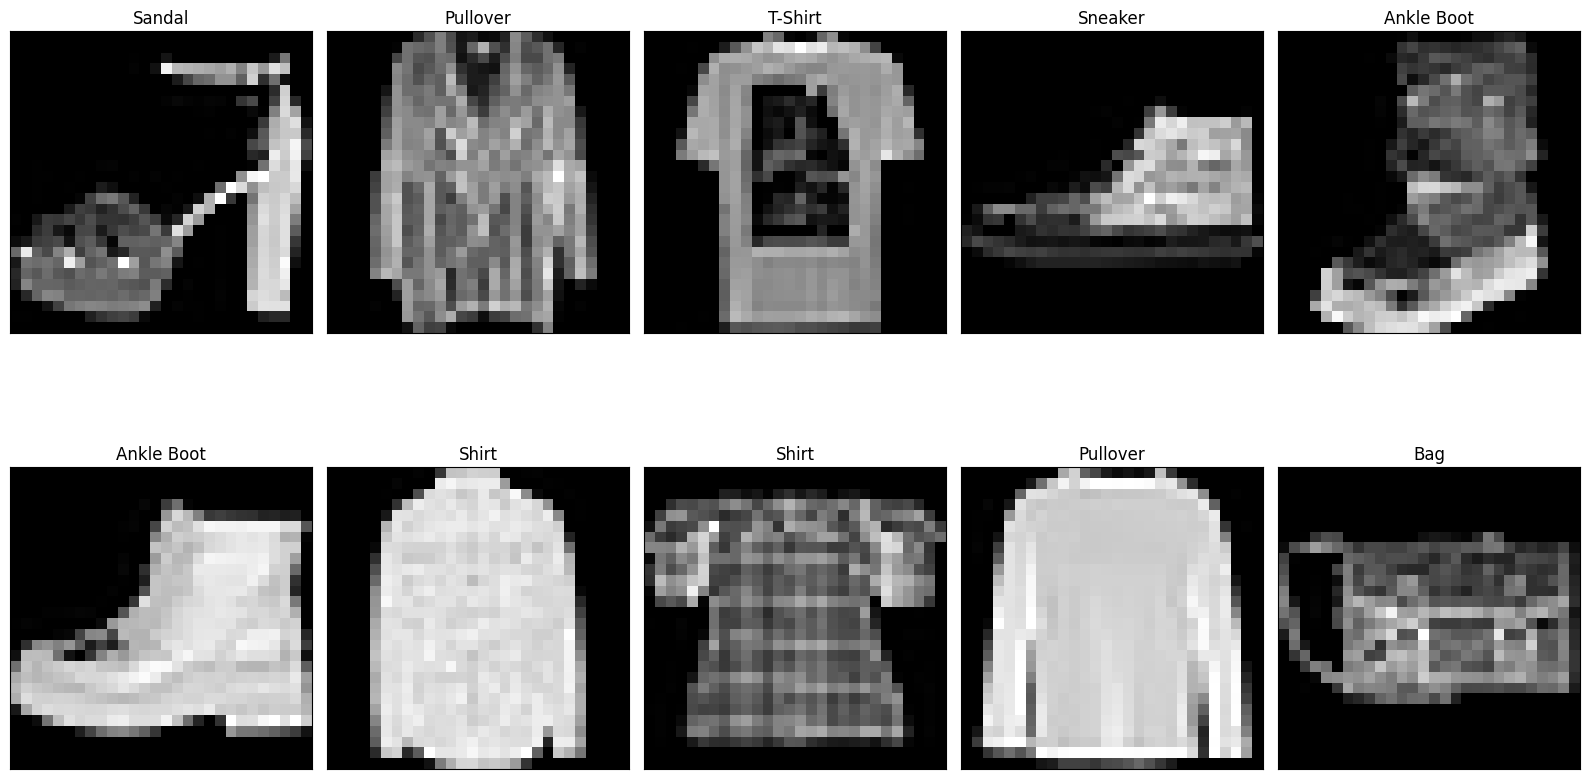

In [5]:
#분류에 사용될 클래스 정의
import matplotlib.pyplot as plt
import numpy as np

# train_loader 에서 첫 번째 배치를 가져와 이미지와 라벨을 sample, labels에 저장
samples, labels = next(iter(train_loader))

# 각 클래스의 이름을 숫자와 매칭하여 저장 (총 10개)
classes = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coar',
5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 10)) # 4행 6열의 서브플롯을 생성

for ax, image, label in zip(axs.flatten(), samples, labels):
    image = np.transpose(image.numpy(), (1, 2, 0)) # 차원 변환: (C, H, W) -> (H, W, C)
    
    ax.imshow(image, cmap='gray') # 흑백 이미지로 출력
    ax.set_title(classes[label.item()], fontsize=12) # label.item(): torch.Tensor 타입의 스칼라 값(정수)을 얻기 위해 사용
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

In [6]:
#합성곱(CNN) 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential( ## 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), ## 2
            nn.BatchNorm2d(32), ## 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 4
        )
       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #완전 연결 신경망 계층 정의
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) ## 5
        self.drop=nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=600, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) ## 6
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [7]:
#합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001 #학습률 설정
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
#모델 학습 및 성능 평가
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs): # 100개의 이미지와 레이블이 하나의 배치로 묶여서 가져옴
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train) # 학습 데이터(batch)를 모델에 입력하여 출력값 계산
        loss = criterion(outputs, labels) # 손실값 계산
        optimizer.zero_grad()  # 이전에 계산된 그래디언트 값 초기화
        loss.backward()        # 손실에 대한 그래디언트 계산
        optimizer.step()       # 계산된 그래디언트를 이용하여 가중치 업데이트
        count += 1
        
        if (count % 50)==0: #  매 50번째 iteration마다 test data를 이용해 accuracy를 계산
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                labels_list.append(labels)
                test = Variable(images.view(-1, 1, 28, 28))
                
                outputs = model(test)
                predictions = torch.argmax(outputs, 1).to(device) # 최댓값의 위치
                predictions_list.append(predictions)
                
                correct += (predictions == labels).sum() # 정답을 맞춘 데이터의 수
                total += len(labels) # 총 데이터의 수
        
            accuracy = correct / total * 100 # 정확도
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
                
        if (count % 500)==0:
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, 
                accuracy))

Iteration: 500, Loss: 0.3574100136756897, Accuracy: 87.54000091552734%
Iteration: 1000, Loss: 0.26989829540252686, Accuracy: 86.80999755859375%
Iteration: 1500, Loss: 0.30860626697540283, Accuracy: 89.52000427246094%
Iteration: 2000, Loss: 0.2911769151687622, Accuracy: 89.79000091552734%
Iteration: 2500, Loss: 0.21870701014995575, Accuracy: 90.1500015258789%
Iteration: 3000, Loss: 0.2429305911064148, Accuracy: 91.30999755859375%


In [16]:
#클래스별로 정확히 분류된 샘플 수를 저장하기 위한 리스트 생성
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
#클래스 별로 정확도 출력
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 89.10%
Accuracy of Trouser: 98.10%
Accuracy of Pullover: 89.10%
Accuracy of Dress: 95.20%
Accuracy of Coat: 85.90%
Accuracy of Sandal: 98.30%
Accuracy of Shirt: 68.70%
Accuracy of Sneaker: 98.60%
Accuracy of Bag: 97.60%
Accuracy of Ankle Boot: 95.00%


In [17]:
from itertools import chain 

#중첩된 리스트를 하나의 단일 리스트로 만듦
predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [18]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
#CCN 모델의 성능을 평가하는 분류 보고서를 출력
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     60000
           1       0.98      0.97      0.98     60000
           2       0.81      0.83      0.82     60000
           3       0.88      0.89      0.88     60000
           4       0.80      0.81      0.81     60000
           5       0.97      0.96      0.97     60000
           6       0.69      0.67      0.68     60000
           7       0.93      0.95      0.94     60000
           8       0.97      0.97      0.97     60000
           9       0.96      0.95      0.95     60000

    accuracy                           0.88    600000
   macro avg       0.88      0.88      0.88    600000
weighted avg       0.88      0.88      0.88    600000


